
# EDA and preparing the data 

This notebook includes some important data exploration, groupings and breakdowns of different features, relvant visualizations and some statistics. Furthermore it builds the dataframe that is used in the model notebook(s) which includes the Naive Bayes calculation.

** ** 
### Includes:
 1. Most Common Diagnoses Fatal v. Non Fatal
 1. * Using Naive Bayes to find diseases that are good features *
  
    \\[\frac{P( Death  |  icd9=x) }{P( Survival | icd9 x)} \\]
    
 1. Combination of Patients and Admissions table
 1. First Model: Gender and Age Logistic Regression
 1. Create DataFrame with icd9- as features
 1. (optional) if you wanna look at ethnicity
 
#### terms in data tables 

* hadm_id    = hospital admission id (one patient could map to several) 
* subject_id = personal id (unique to patient)
* seq_num    = sequential number of diagnosis ( 1 being most serious/reason for coming in)  

### outline

1. Part 1:  Answering a few basic stats
1. Part 2: Visualization,  Histograms 
1. Part 7 (?) First Logistic Model: Gender, Age, Admission type


In [1]:
from __future__ import print_function, division

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [4]:
####import all the previously assembled data 

# general dataframe with more info: time, gender, language etc
data = pd.read_csv("mimic_data/admit_1.csv")
### dataframe containing all diagnosis codes for hospital visits tagged: expired/fatal 
df_expired = pd.read_csv("mimic_data/icd9_expire1.csv")

# dataframe containing all diagnosis codes for hospital visits tagged: survived
df_alive = pd.read_csv("mimic_data/icd9_expire0.csv")

# dataframe containing all diagnoses (short & long) for all hospital visits
diagnoses = pd.read_csv("mimic_data/diagnoses.csv")

# DICTIONARY of DIAGNOSES (procedures);  only 3882 rows 
procedures = pd.read_csv("mimic_data/procedures.csv")

#### Data files key 
* **df_alive** - every single icd9 code for every single hospital visit  -- survived
* **df_expired** - every single icd9 code for every single hospital visit -- fatal

** Data ** contains gender, dob, (religion, ethnicity etc. other events)
    - contains:
        - number of unique hospital visits
        - expire flag
        - gender
    - does not contain
        - all icd9-codes per visit and seq_number (order of code importance)  
** diagnoses **
   - icd9- codes and seq_num for all visits 

In [5]:
data[:2]

,subject_id,gender,dob,dod,expire_flag,row_id,subject_id.1,hadm_id,admittime,dischtime,...,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_ioevents_data,has_chartevents_data
0,30,M,1872-10-14 00:00:00,NaN,0,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,...,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,1
1,8402,M,2105-06-24 00:00:00,NaN,0,10260,8402,177676,2167-07-31 09:26:00,2167-08-07 14:36:00,...,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1,1


In [6]:
df_expired[:2]

,hadm_id,subject_id,expire_flag,icd9_code
0,121205,91,1,20008
1,121205,91,1,2765


In [7]:
df_alive[:3]

,hadm_id,subject_id,expire_flag,icd9_code
0,163353,2,0,V3001
1,163353,2,0,V053
2,163353,2,0,V290


In [8]:
diagnoses[:2]

,row_id,subject_id,hadm_id,seq_num,icd9_code,row_id.1,icd9_code.1,short_title,long_title
0,243,34,115799,8.0,E8790,13429.0,E8790,Abn react-cardiac cath,Cardiac catheterization as the cause of abnorm...
1,244,34,144319,1.0,42789,4471.0,42789,Cardiac dysrhythmias NEC,Other specified cardiac dysrhythmias


In [9]:
procedures[:3]

,row_id,icd9_code,short_title,long_title
0,86,64,Perc ins extracran stent,Percutaneous insertion of other extracranial a...
1,87,65,Perc ins intracran stent,Percutaneous insertion of intracranial vascula...
2,88,66,PTCA,Percutaneous transluminal coronary angioplasty...


In [10]:
print (" all hospital visits in data \t", len(data['hadm_id'].unique()))
print ( " all hospital visits in diagnoses \t",len(diagnoses['hadm_id'].unique()))
print ( " \t codes \t")
print ("all codes in procedures " ,len(procedures['icd9_code'].unique()))
print ("all codes in diagnoses \t" ,len(diagnoses['icd9_code'].unique()))
print ("all codes in df_alive \t" ,len(df_alive['icd9_code'].unique()))
print ("all codes in df_expired " ,len(df_expired['icd9_code'].unique()))

 all hospital visits in data 	 58976
 all hospital visits in diagnoses 	 58976
 	 codes 	
all codes in procedures  3809
all codes in diagnoses 	 6985
all codes in df_alive 	 6423
all codes in df_expired  4824


In [11]:
## diagnoses.groupby('hadm_id').count() # returns DF with number codes per visit
## diagnoses.groupby('')

 # Part 1:  Answering a few basic stats

#### regarding data frames

the goal is to obtain a dataframe of admissions with both expired flag [ survived/expired ] and also obtain an idea of what are the most common icd9 codes

+ ** admit_1.csv ** used to get # admissions + expire_flag
+ ** icd9_expire.csv ** to find the most common icd9 codes

** ** ** 
     # How many unique codes for fatal cases?  4824
     #How many unique codes for survived cases? 6423
    **

In [12]:
# How many unique codes for fatal cases? 
len(df_expired.icd9_code.unique())

4824

In [13]:
#How many unique codes for survived cases? 
len(df_alive.icd9_code.unique())

6423

In [14]:
# info on the data types in diagnoses
diagnoses.info()
# How many unique codes present in diagnoses? 
len(diagnoses.icd9_code.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 9 columns):
row_id         651047 non-null int64
subject_id     651047 non-null int64
hadm_id        651047 non-null int64
seq_num        651000 non-null float64
icd9_code      651000 non-null object
row_id.1       634709 non-null float64
icd9_code.1    634709 non-null object
short_title    634709 non-null object
long_title     634709 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 44.7+ MB


6985

In [15]:
df_expired.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719641 entries, 0 to 719640
Data columns (total 4 columns):
hadm_id        719641 non-null int64
subject_id     719641 non-null int64
expire_flag    719641 non-null int64
icd9_code      719552 non-null object
dtypes: int64(3), object(1)
memory usage: 22.0+ MB


In [16]:
data.head(2)

,subject_id,gender,dob,dod,expire_flag,row_id,subject_id.1,hadm_id,admittime,dischtime,...,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_ioevents_data,has_chartevents_data
0,30,M,1872-10-14 00:00:00,NaN,0,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,...,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,1
1,8402,M,2105-06-24 00:00:00,NaN,0,10260,8402,177676,2167-07-31 09:26:00,2167-08-07 14:36:00,...,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1,1


##### adjust age 
due to anonymization lots of ages are set at much smaller than 0; these are actually really old people, set all these ages to 90

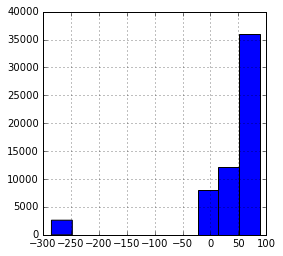

In [17]:
######### ADD AGE 
# Age, the -285 is over 90
# ('<m8[Y]') is a dtype, that rounds up the years

data['age'] = (pd.to_datetime(data.admittime) - pd.to_datetime(data.dob )
              ).astype('<m8[Y]')

data['age'].hist(figsize=(4,4));

#### SET ALL SMALLER THAN 0 AGES TO 90
data.loc[ (data.age < 0),'age']  = 90.0

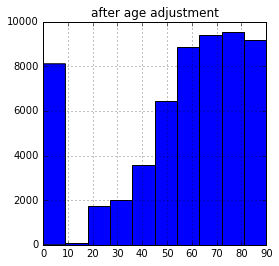

In [18]:
data['age'].hist(figsize=(4,4))
plt.title('after age adjustment');

In [19]:
# dob year
data['year']=  pd.DatetimeIndex(data['dob']).year

In [20]:
data[:3]

,subject_id,gender,dob,dod,expire_flag,row_id,subject_id.1,hadm_id,admittime,dischtime,...,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_ioevents_data,has_chartevents_data,age,year
0,30,M,1872-10-14 00:00:00,NaN,0,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,...,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,1,90.0,1872
1,8402,M,2105-06-24 00:00:00,NaN,0,10260,8402,177676,2167-07-31 09:26:00,2167-08-07 14:36:00,...,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1,1,62.0,2105
2,146,M,2034-05-31 00:00:00,2124-12-30 00:00:00,1,196,146,190707,2119-12-19 12:15:00,2120-01-10 13:08:00,...,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,CONGESTIVE HEART FAILURE\CATH,0,1,1,85.0,2034


In [21]:
# unused
#data[data['year'] > 2016].count()

In [22]:
#pd.to_datetime(data.dob)
#.apply(lambda x: x.strftime('%B-%Y'))  #.astype('<m8[Y]')

In [23]:
data.columns

Index([u'subject_id', u'gender', u'dob', u'dod', u'expire_flag', u'row_id',
       u'subject_id.1', u'hadm_id', u'admittime', u'dischtime', u'deathtime',
       u'admission_type', u'admission_location', u'discharge_location',
       u'insurance', u'language', u'religion', u'marital_status', u'ethnicity',
       u'edregtime', u'edouttime', u'diagnosis', u'hospital_expire_flag',
       u'has_ioevents_data', u'has_chartevents_data', u'age', u'year'],
      dtype='object')

# Part2: Visualization,  Histograms 

breakdown data by age, gender, and the expire flag and look at what the distribution looks like 

    ** Number of survived/fatal cases by age
    ** Number of survived/fatal cases by gender
        ** CHECK MORTALITY DISTRIBUTION BY % (GENDER) 

In [24]:
#data.loc[(data['expire_flag']==0), 'age']
data[data['age']<10.0][:3]

,subject_id,gender,dob,dod,expire_flag,row_id,subject_id.1,hadm_id,admittime,dischtime,...,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_ioevents_data,has_chartevents_data,age,year
55,16414,F,2180-02-21 00:00:00,NaN,0,20044,16414,142208,2180-03-03 12:34:00,2180-03-05 12:45:00,...,NaN,ASIAN,NaN,NaN,HYPERBILIRUBIMIA,0,1,1,0.0,2180
65,15593,F,2143-01-27 00:00:00,NaN,0,19041,15593,150263,2143-02-01 17:39:00,2143-02-04 13:16:00,...,NaN,WHITE,NaN,NaN,HYPERBILIRUBINEMIA,0,1,1,0.0,2143
153,14258,M,2136-02-03 00:00:00,NaN,0,17464,14258,109672,2136-02-03 20:37:00,2136-02-09 18:57:00,...,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,PREMATURITY,0,1,1,0.0,2136


In [25]:
## Create series for adolescent and adult patients (no children under 10)
fatal_series = data.loc[(data['expire_flag']==1),'age' ]
fatal_series = fatal_series[fatal_series>10]

survive_series = data.loc[(data['expire_flag']==0),'age' ]
survive_series = survive_series[survive_series>10]

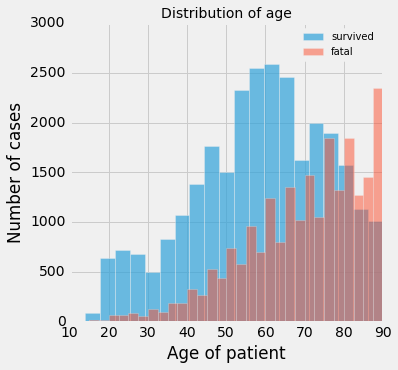

In [26]:
## choose and savewhichever style works better
#plt.style.use('bmh')
plt.style.use('fivethirtyeight')
plt.figure(figsize = (5,5))
plt.hist(survive_series, bins=20, alpha=0.7, label='survived') #color='purple',
plt.hist(fatal_series, bins=30,alpha=0.5, label = 'fatal')

plt.title('Distribution of age', fontsize=14)
plt.legend(fontsize=10)
plt.xlabel('Age of patient')
plt.ylabel('Number of cases');
#plt.savefig('Age_dist')

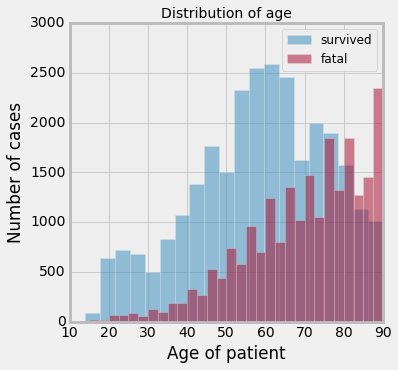

In [27]:
plt.style.use('bmh')
plt.figure(figsize = (5,5))
plt.hist(survive_series, bins=20, alpha=0.5, label='survived') #color='purple',
plt.hist(fatal_series, bins=30,alpha=0.5, label = 'fatal')
plt.title('Distribution of age', fontsize=14)
plt.legend(fontsize=12); plt.xlabel('Age of patient'); plt.ylabel('Number of cases');
#plt.savefig('Age_dist')

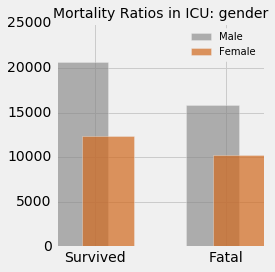

In [28]:
# 0-M, 1-F
plt.style.use('fivethirtyeight')
g_0 = data.loc[(data['expire_flag']==0),'gender' ].value_counts() # survived M/F
g_1 = data.loc[(data['expire_flag']==1),'gender' ].value_counts() # fatal M/F

plt.figure(figsize = (4,4))
x = np.arange(0,2)
wid = 0.4

plt.bar(x+0.2, g_0, wid, alpha=0.6, label='Male',color='grey',)#  'male'
plt.bar(x+ 0.4, g_1, wid,alpha=0.7, label = 'Female', color='chocolate') # 'female'
plt.xticks(x+0.5, ['Survived', 'Fatal'])
plt.title('Mortality Ratios in ICU: gender', fontsize=14)
plt.tight_layout()  #plt.savefig('gender')
plt.legend(fontsize=10);

more males than females were admitted; Plot expire_flag (0:1) as a **percentage** of all admitted broken down by gender

In [29]:
pd.DataFrame(data.loc[(data['gender']=='M'),'expire_flag' ].value_counts() )

,expire_flag
0,20600
1,12350


In [32]:
#m_0 = m_0.rename(columns={'expire_flag':'count'}).reset_index()
#m_0.rename(columns={'index':'expire_flag'},inplace=True)

In [31]:
m_0 = pd.DataFrame(data.loc[(data['gender']=='M'),'expire_flag' ].value_counts()) # survived M/F
f_0 = pd.DataFrame(data.loc[(data['gender']=='F'),'expire_flag' ].value_counts()) # fatal M/F

m_0['gender'] = 'M'
f_0['gender'] = 'F'
m_0['expire_percent'] = (m_0['expire_flag'].div(m_0.expire_flag.sum())*100).apply(lambda x: round(x,2))
f_0['expire_percent'] = (f_0['expire_flag'].div(f_0.expire_flag.sum())*100).apply(lambda x: round(x,2))
# expire flag and count columns
m_0 = m_0.rename(columns={'expire_flag':'count'}).reset_index()
m_0.rename(columns={'index':'expire_flag'},inplace=True)
f_0 = f_0.rename(columns={'expire_flag':'count'}).reset_index()
f_0.rename(columns={'index':'expire_flag'},inplace=True)

gender_frames = pd.concat([m_0,f_0])


/Users/billierolih/anaconda/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [36]:
expire = ["survived", "fatal"]
n_g = ['0','1']
gender_frames['expire_flag'] = gender_frames['expire_flag'].astype(str)
gender_frames.expire_flag.replace(n_g,expire, inplace=True)

In [37]:
gender_frames

,expire_flag,count,gender,expire_percent
0,survived,20600,M,62.52
1,fatal,12350,M,37.48
0,survived,15790,F,60.67
1,fatal,10236,F,39.33


#### Part 2b. :  Hospital admits more men, what is the survival rate by gender? 

In [38]:
gender_frames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 1
Data columns (total 4 columns):
expire_flag       4 non-null object
count             4 non-null int64
gender            4 non-null object
expire_percent    4 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 160.0+ bytes


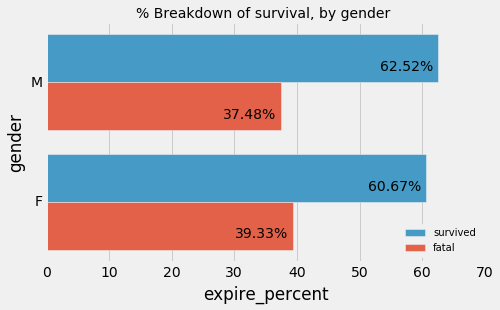

In [64]:
plt.figure(figsize=(7,4))
ax = sns.barplot(x="expire_percent", y="gender", hue="expire_flag",data=gender_frames)
ax.legend(fontsize=10, loc=4)
ax.set_title("% Breakdown of survival, by gender ",fontsize = 14 )
# ax.text (gender_frames.expire_percent)
for p in ax.patches:
    width = p.get_width()
    ax.text(width - 5, #+p.get_height()/2.,
            p.get_y()+p.get_height()/2 +0.1,
            '{:1.2f}%'.format(width),#width/total),
            ha="center");
#show()
#plt.savefig('survival_by_gender');

In [72]:
ma = gender_frames[gender_frames.gender=='M']['count'].sum() 
fa =gender_frames[gender_frames.gender=='F']['count'].sum() 
print(" Number of male admissions ", ma)
print(" Number of female admissions ",fa )
print (" difference", ma - fa)
print ("% of total", round((ma-fa)/(ma+fa)*100, 2))

 Number of male admissions  32950
 Number of female admissions  26026
 difference 6924
% of total 11.74


The hospital admits more men (almost 7000, about 12% more) but observes 2% higher fatalities in women.

Is this statistically significant? 

### I think we wanna do a Chi-square test here** .

**T-test** 
A t-test is a statistical test that can help us estimate whether the difference in a numerical measure between two groups is reliable. 

###### Chi-Test Null hypothesis
    there is no difference in fatal cases in the categorical value "gender" i.e. that the observed and expected frequencies are the same.

In [82]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import chisquare
# interpret test-statistic
prob = 0.95

In [84]:
gender_frames

,expire_flag,count,gender,expire_percent
0,survived,20600,M,62.52
1,fatal,12350,M,37.48
0,survived,15790,F,60.67
1,fatal,10236,F,39.33


To do a one-way chi square test on expire_flag/ Gender?? Do it on a subset of data, which includes gender, and expire flag

In [90]:
data.loc[:,['gender', 'expire_flag']][:3]

,gender,expire_flag
0,M,0
1,M,0
2,M,1


In [93]:
data.loc[:,'gender'].value_counts()

M    32950
F    26026
Name: gender, dtype: int64

In [94]:
# first let's do a one-way chi-squared test for M/F in gender_frame
#scipy.stats.
chisquare(data.loc[:,'gender'].value_counts())

Power_divergenceResult(statistic=812.9031470428649, pvalue=8.447194609871837e-179)

##### Interpretation
The larger the statistic (the chi-squared statistic) the more difference there is from a uniform distribution. We can be sure that the genders are not all equally likely to be admitted to the hosptial 

Now let's find out: is there a relationship between gender and fatality? 

In [96]:
contingency_table=pd.crosstab(data['gender'],data['expire_flag'])
contingency_table

expire_flag,0,1
gender,,
F,15790,10236
M,20600,12350


In [97]:
chi2_contingency(contingency_table)

(20.956179870969887,
 4.699095218712981e-06,
 1,
 array([[16058.83986706,  9967.16013294],
        [20331.16013294, 12618.83986706]]))

1. Chi-squared value
1. p-value, which is very very small here; it seems unlikely there is no connection between gender and the expire flag 

we ran two different tests with small p value, it seems unlikely this is random variability, and gender seems a good feature to keep 

In [73]:
# ############ Admission_type into categorical 
cols_a = ['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']
nums_a = [0, 1, 2, 3 ]
print(data.admission_type.unique())
print(cols_a)

data.admission_type.replace(cols_a, nums_a, inplace=True)
adm_alive = data.loc[(data['expire_flag']==0),'admission_type' ]
adm_fatal = data.loc[(data['expire_flag']==1),'admission_type' ]

['URGENT' 'NEWBORN' 'EMERGENCY' 'ELECTIVE']
['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']


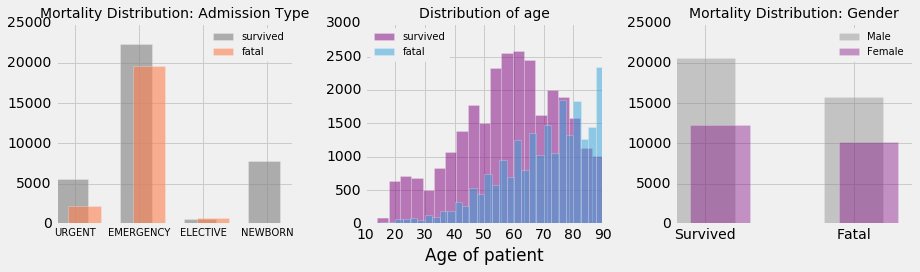

In [79]:
"""
   combined plot 
"""
fig, ax = plt.subplots(1,3, figsize = (13,4))

x = np.arange(0,4)
wid = 0.5
ax[0].bar(x+0.2, adm_alive.value_counts().sort_index(ascending=False), 
          wid, alpha=0.6,color='grey', label='survived')
#adm_alive.value_counts().sort_index(ascending=False).plot.barh()
ax[0].set_xticks(x+0.5)
ax[0].set_xticklabels(['URGENT', 'EMERGENCY', 'ELECTIVE','NEWBORN'],fontsize=10)
#ax[0].set_yticklabels(fontsize=10)
ax[0].bar(x+ 0.4, adm_fatal.value_counts().sort_index(ascending=False), 
          wid,alpha=0.6, color='coral', label='fatal')
ax[0].legend(fontsize=10)
ax[0].set_title('Mortality Distribution: Admission Type', fontsize=14)


ax[1].hist(survive_series, bins=20,color='purple', alpha=0.5, label='survived')
ax[1].hist(fatal_series, bins=30,alpha=0.5, label = 'fatal')

ax[1].set_title('Distribution of age', fontsize=14)
ax[1].legend(fontsize=10, loc=2)
ax[1].set_xlabel('Age of patient')
#ax[1].set_ylabel('Number of cases')

x1 = np.arange(0,2)
wid1 = 0.4

ax[2].bar(x1+0.2, g_0, wid1, alpha=0.4,color='grey', label='Male')
ax[2].bar(x1+ 0.3, g_1, wid1,alpha=0.4, label = 'Female', color='purple')
ax[2].set_xticks(x1+0.4)
ax[2].set_xticklabels(['Survived', 'Fatal'])
ax[2].set_title('Mortality Distribution: Gender', fontsize=14)
ax[2].legend(fontsize=10);

plt.tight_layout() 
#plt.savefig('ALL_Distributions')

#plt.savefig('Age_dist')

In [ ]:
ax = sns.barplot(x=m_0.index, y='expire_percent', data=m_0)
ax = sns.barplot(x=f_0.index, y='expire_percent', data=f_0)
#             estimator= lambda x: sum(x==0)*100.0/len(x) )
ax.set(ylabel="Percent", xlabel='Survival')

In [80]:
adm_fatal.value_counts().sort_index(ascending=False)

3     2186
2    19650
1      685
0       65
Name: admission_type, dtype: int64

In [ ]:
plt.figure(figsize = (4,4))
x = np.arange(0,4)
wid = 0.5

plt.bar(x+0.2, adm_alive.value_counts().sort_index(ascending=False), wid, alpha=0.6,
        color='grey', label='survived')
plt.xticks(x+0.5, cols_a,fontsize=10)
plt.yticks(fontsize=10)

plt.bar(x+ 0.4, adm_fatal.value_counts().sort_index(ascending=False), wid,alpha=0.6,  
        color='coral', label='fatal')

In [ ]:
adm_alive.value_counts().sort_index(ascending=False)

In [ ]:
########### Gender ##########
gen = ["M", "F"]
n_g = [0,1]
data.gender.replace(gen, n_g, inplace=True)

In [ ]:
## interrupted, the rugplot takes a while
x_0 =data.loc[(data['expire_flag']==0),'age' ]
x_1 = data.loc[(data['expire_flag']==1),'age' ]

sns.distplot(x_0[x_0>10], kde=False, rug=True)
sns.distplot(x_1[x_1>10], kde=False, rug=True)

plt.title('Surival distribution by age',fontsize = 14);

In [ ]:

# x = np.arange(10)
# wid = 0.4

# plt.bar(0.5+x, tmp_fatal.num_expire_flags, wid, label='fatal admission')
# plt.xticks(x, cols, rotation=35, fontsize=14)

In [ ]:
data[:3]

In [ ]:
# more men admitted to ICU
print(g_0)
print(g_1)
print ("men " ,20600 +  12350)
print ("women " , 15790 +  10236)

## Most common icd9 codes fatal/survival; Data Frames


In [ ]:
df_expired[:3]

In [ ]:
# the most common icd9_code
new_icd9 = (df_expired.groupby('icd9_code')
 .count()
.reset_index().sort_values('expire_flag', ascending=False))

new_icd9.rename(columns={'expire_flag':'num_expire_flags'}, inplace=True)

In [ ]:
## 10 most common codes; but what are they? 
new_icd9_smaller = new_icd9.iloc[:50,:]
#[['icd9_code']][:20]

In [ ]:
len(new_icd9_smaller)
new_icd9_smaller[:3]
### remove hadm_id and subject_id (these are aggregates anyway)
new_icd9_smaller.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)

In [ ]:
new_icd9_smaller[:3]

### Join common icd9_codes to DIAGNOSES
-- find what the 50 most common DIAGNOSES
-- do an inner join, keep only rows preset
    - merge left on id9 code ( smaller, larger)

#### SEQ_NUM is from DIAGNOSES
-- SEQ_NUM provides the order in which the ICD diagnoses relate to the patient. ICD diagnoses are ordered by priority - and the order does have an impact on the reimbursement for treatment.



In [ ]:
# diagnoses.drop(['icd9_code.1', 'row_id.1'], axis=1, inplace=True)
# diagnoses.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)
diagnoses.drop(['seq_num', 'row_id'], axis=1, inplace=True)

In [ ]:
## THE 10 most common diagnoses (irrespective of Expire_Flag)
diagnoses['short_title'].value_counts()[:10]

In [ ]:
diagnoses[:2]

In [ ]:
merged_MOSTCOMMONicd9 = pd.merge(new_icd9_smaller, diagnoses, how='left',on='icd9_code')

In [ ]:
merged_MOSTCOMMONicd9[:2]

# Table of most common Diagnoses (long-title) ; Fatal

In [ ]:
tmp_fatal = (merged_MOSTCOMMONicd9.
groupby('icd9_code')
 .first()
 .reset_index().sort_values('num_expire_flags', ascending=False))[:10]

In [ ]:
cols1 = ['Congestive heart failure','Hypertension' ,'Atrial fibrillation','Kidney failure', 'Coronary artery disease',
       'Respiratory failure', 'Diabetes', 'Urinary tract infection', 'Pneumonia','Airway obstruction']
mylist = pd.Series(cols1)
mylist.values
tmp_fatal['common'] = mylist.values

In [ ]:
tmp_fatal

In [ ]:
tmp_fatal.long_title.values

In [ ]:
tmp_alive.long_title.values

In [ ]:
plt.figure(figsize = (6,6))
x = np.arange(10)
wid = 0.4

plt.barh(0.5+x, tmp_fatal.num_expire_flags, wid, label='fatal admission')
plt.yticks(x+0.6, cols1, fontsize=14)
plt.legend()
plt.tight_layout()  
plt.savefig('fatal_diagnoses',DPI=600);

In [ ]:
plt.figure(figsize = (10,5))
x = np.arange(10)
wid = 0.4

plt.bar(0.5+x, tmp_fatal.num_expire_flags, wid, label='fatal admission')
plt.xticks(x, cols1, rotation=35, fontsize=14)
plt.legend()
plt.tight_layout()  
plt.savefig('fatal_diagnoses',DPI=600);

In [ ]:
plt.figure(figsize = (10,5))
x = np.arange(10)
wid = 0.4

plt.bar(0.5+x, tmp_alive.num_alive_flags, wid, color='purple', label='survived admission')
plt.xticks(x, cols2, rotation=35, fontsize=14)
plt.legend()
plt.tight_layout() 
plt.savefig('survived_diagnosis');

# Table of most common Diagnoses (long-title) ; NON-Fatal
+ first obtain a dataset icd9_expire0a.csv"

In [ ]:
#df_alive
new_alive = (df_alive.groupby('icd9_code')
 .count()
.reset_index().sort_values('expire_flag', ascending=False))

new_alive.rename(columns={'expire_flag':'num_alive_flags'}, inplace=True)
### remove hadm_id and subject_id (these are aggregates anyway)
new_alive.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)
##
new_alive_smaller = new_alive.iloc[:50,:]

In [ ]:
#new_alive_smaller
merged_MOSTCOMMONalive = pd.merge(new_alive_smaller, diagnoses, how='left',on='icd9_code')

In [ ]:
#group merged acccording to count
tmp_alive =(merged_MOSTCOMMONalive
.groupby('icd9_code')
.first()
.reset_index().sort_values('num_alive_flags', ascending=False))[:10]

In [ ]:
cols2 = ['Hypertension' , 'Congestive heart failure','Coronary artery disease', 'Hyperlipidemia',
         'Atrial fibrillation', 'Kidney failure', 'Acid Reflux', 'Diabetes', 'Anemia', 
       'Hepatitis vaccine']
mylist2 = pd.Series(cols)
mylist2.values
tmp_alive['common'] = mylist2.values
tmp_alive

In [ ]:
tmp_alive[]

# Naive bayes: find good features from Diagnoses using Likelihood model

**data tables** : new_alive, new_icd9


\\[\frac{P(death | icd9 =x) }{P(survival | icd9 =x)} = prior* \frac{ P(icd9 = x | death) }{P(icd9 = x | survival)} \\]

\\[  = prior* \frac{ \frac{count Deaths}{All Deaths}} {\frac{count Survival}{All Survival}} \\]


+ this second fraction I have
+ the baseline/prior is just the ratio of total_death/total_survival

In [ ]:
# finish Clean up; don't need hadm_id/subject_id here 
new_icd9.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)


In [ ]:
### use pre-merged Fatal/Alive Data frames
print( " Number of unique icd9 codes for Survival + Fatal admissions: ", len(new_alive), len(new_icd9))

new_alive[:3]

In [ ]:
new_icd9[:2]

1. Number of AND type of 1cd9_code which have NO Fatal admission: 
    + merge, set as N/A for num_expire_flags in new_icd9 

In [ ]:
# from Part 3 : below 
total_fatal = 22586
total_survival =  36390

In [ ]:
# merge left on new_icd9, ie. keep all of icd9
merged_nbayes = pd.merge(new_icd9, new_alive, how='right', on='icd9_code')

In [ ]:
#P_icd9_Death
merged_nbayes['P_icd9_Survival']= merged_nbayes.num_alive_flags/total_survival
#P_icd9_Survival
merged_nbayes['P_icd9_Death']=merged_nbayes.num_expire_flags/total_fatal

In [ ]:
merged_nbayes[:3]

In [ ]:
# P(survival | icd9)
baseline* (0.317340)

In [ ]:
# P(death | icd9)
baseline*(0.900514)

## What is Ratio_Pd_Ps? + Add  Diagnoses Dictionary
The exact question we are answering here: give icd9 = x, what are the odds of Death over Survival? 

In [ ]:
# Calculate Ratio_Pd_Ps: ratio of Death to Survival
baseline = total_fatal/total_survival

#Ratio_Pd_Ps
merged_nbayes['Ratio_Pd_Ps']= baseline*merged_nbayes.P_icd9_Death/merged_nbayes.P_icd9_Survival

In [ ]:
merged_nbayes[:3]

In [ ]:
# some of the Lowest values (these icd9 Codes suggest that )
merged_nbayes.sort_values('Ratio_Pd_Ps')[:10]

In [ ]:
#pd.merge(new_alive_smaller, diagnoses, how='left',on='icd9_code')

merged_FIN = (pd.merge(merged_nbayes, diagnoses, how='left', on='icd9_code'))

In [ ]:
merged_FIN


In [ ]:
# 20 most common icd9 numbers for observed POSITIVE Survival Odds
most_Survival = (merged_FIN
.groupby('icd9_code')
.first()
.reset_index().sort_values('Ratio_Pd_Ps'))[['icd9_code','num_expire_flags','num_alive_flags','Ratio_Pd_Ps','short_title','long_title']][:15]

In [ ]:
most_Survival

In [ ]:
most_Death = (merged_FIN
.groupby('icd9_code')
.first()
.reset_index().sort_values('Ratio_Pd_Ps', ascending=False))[['icd9_code','num_expire_flags','num_alive_flags','Ratio_Pd_Ps',
                                                             'short_title','long_title']][:50]

In [ ]:
zed = most_Death[['icd9_code','num_expire_flags', 'num_alive_flags', 'Ratio_Pd_Ps', 'long_title']]

zed.loc[ze866,:]

In [ ]:
zed.loc[zed['icd9_code']=='1972',:]
zed.loc[zed['icd9_code']=='1984',:].long_title.values

zed.loc[zed['icd9_code']=='99685',:]
zed.loc[zed['icd9_code']=='51181',:]# 485
zed.loc[zed['icd9_code']=='07041',:]

In [ ]:
zed

In [ ]:
zed.loc[485,:]

In [ ]:
## Number of NAN flags in expire_flags
merged_nbayes[merged_nbayes.num_expire_flags.isnull()].count()

In [ ]:
# there are no icd9_codes that are automatic surivval!!
merged_nbayes[merged_nbayes.num_alive_flags.isnull()].count()

# 5 Create dataFrame with icd9 - as features
start with Admission-Patient data called "data

In [ ]:
# drop NAN values
most_Death = most_Death.dropna()

In [ ]:
#list(most_Death.icd9_code)

In [ ]:
icd9_features = most_Death.icd9_code.values

In [ ]:
icd9_features

In [ ]:
len(icd9_features) # 47 new features

In [ ]:
######### Cleaning data 

# df_model = data.drop( ['hospital_expire_flag', 'has_ioevents_data', 'has_chartevents_data', u'edregtime',
#            u'edouttime' ], axis = 1)
# df_model = df_model.drop( [ u'insurance', u'language', u'religion', u'marital_status', u'ethnicity' ], axis = 1)
# df_model = df_model.drop( [u'admission_location', u'discharge_location',u'admittime', u'dischtime', u'deathtime',u'row_id',], axis = 1)

# df_model = df_model.drop( [ u'dob', u'dod', u'subject_id.1' ], axis = 1)

df_model

##### ADD ICD-9 to df_model 
+ merge df_expired onto df_model (for expire_flag=1) 
+ merge df_alive

In [ ]:
##### Concatinate fatal + alive icd9-code Data Frames
print (len(df_expired))
print ( len(df_alive))

frames = [df_expired, df_alive]

result = pd.concat(frames)

In [ ]:
len(df_model)

In [ ]:
len(result)

In [ ]:
df_model.head(2)

In [ ]:
icd9_features

In [ ]:
len(result)

In [ ]:
# may not need this
#codes = result.icd9_code.unique()

In [ ]:
### Retain all rows in result 
result.head(5)
#result[result.icd9_code=='27953']

In [ ]:
### Retain all rows in result : left merge 
    ## there shouldn't be any hadm_id's in df_model NOT in result
    ## if there are, not interesting, because we need icd9_codes
    
df_model  = pd.merge(result, df_model, how='left', on='hadm_id')

In [ ]:
df_model = df_model.drop(['expire_flag_y','subject_id_y'], axis=1)

In [ ]:
df_model.head()

In [ ]:
icd9_features

In [ ]:
############ add columns 
# for var in icd9_features:
#     df_model[var] = 0

In [ ]:
### group by admissions ID, if icd9 code is 
df_model[df_model.hadm_id==100018]

In [ ]:
df_model[df_model.hadm_id==121205]

In [ ]:
df_model['d']=1
df_model

In [ ]:
df_tmp = (df_model.
 groupby('hadm_id')['hadm_id','subject_id_x','expire_flag_x','gender','admission_type','diagnosis','age']
 .head(1)
  )

In [ ]:
keep;

In [ ]:
tmp = pd.pivot_table(df_model, values='d', index=['hadm_id','subject_id_x'], columns=['icd9_code'])

In [ ]:
tmp.columns

In [ ]:
tmp.columns.name = ''

In [ ]:

tmp.reset_index(col_level=0, inplace = True)

In [ ]:
tmp.head()

In [ ]:
keep

In [ ]:
new_keep = keep[8:].union(keep[0:2])
#keep[0:2].union(keep[8:]keep[0:2])

In [ ]:
new_keep

In [ ]:
tmp.info()

In [ ]:
new_tmp = tmp.loc[:,new_keep]

In [ ]:
new_tmp.fillna(0, inplace=True)

In [ ]:
# testing newtmp
new_tmp[new_tmp['07031']==1]

#### Merge



In [ ]:
df_tmp[:2]

In [ ]:
print(len(df_tmp))
print(len(new_tmp))
#(pd.merge(merged_nbayes, diagnoses, how='left', on='icd9_code'))

In [ ]:
merged_FINAL = pd.merge(df_tmp, new_tmp, how='left', on='hadm_id')

In [ ]:
merged_FINAL.drop('subject_id_x_y', axis=1, inplace=True)

In [ ]:
merged_FINAL.rename(columns={'subject_id_x_x': 'subject_id','expire_flag_x':'expire_flag' },inplace=True)

In [ ]:
merged_FINAL[:3]

# FINAL DATAFRAME TO BE SAVED

In [ ]:
merged_FINAL.to_csv('data_model1.csv', index=None)

In [ ]:
tmp.info()

In [ ]:
tmp

In [ ]:
###### NOT USED 
# mydict={}
# #tmp = grouped['icd9_code'].apply(lambda x: [x] )
# #{k: g["value"].tolist() for k,g in ptest.groupby("id")}

# mydict = {k: g["icd9_code"].tolist() for k,g in df_model.groupby('hadm_id')}

In [ ]:
###### NOT USED 
# #first2pairs = {k: mydict[k] for k in sorted(mydict.keys())[:1]}
# ### Key = hadm_id
#     # vals: icd9_code
# first2pairs = {k: mydict[k] for k in mydict.keys()[:1]}
# first2pairs

In [ ]:
#################### remove 'icd9_code' column and group by 	hadm_id get smaller dataFrame (back to 59,000)

In [ ]:
# df_model = (df_model.groupby('hadm_id')
#  .first()
#  .reset_index())

#### NOW YOU CAN DROP THE  icd9_code

In [ ]:
# #### NOW YOU CAN DROP THE 
# df_model = df_model.drop(['icd9_code'], axis=1)

In [ ]:
df_model.head(4)

In [ ]:
#columns to keep
keep = df_model.columns
keep 

In [ ]:
# # for a in mydict[100001]:
# #     print (a)
# len(mydict[100018])

In [ ]:
###### NOT USED 
# #key is hadm_id
# # traverse df_model.hadm_id use key-value

# for ix in range(len(df_model)):
   
#     key= df_model.loc[ix, 'hadm_id']
    
#     # traverse the array in mydict[key]
#     for a in mydict[key]: 
#         if a in icd9_features:
#             print(key, a)
#             #df_model.loc[ix,a] = 1  
    

In [ ]:
df_model.info()

In [ ]:
#result.loc[(result.hadm_id ==111199 )& (result.icd9_code=='485')]['expire_flag']

In [ ]:
procedures[:2]

In [ ]:
# 4th 
procedures.loc[procedures['icd9_code']== 	5849]

In [ ]:
pd.merge(new_icd9_smaller, procedures, how='left',on='icd9_code');

# 3. Combination of Patients and Admissions table
+ admissions have a: unique HADM_ID
+ 
goals
+ get the age of the subject at admit-time

## First: get total number of Deaths and Survivals

In [ ]:
## How many subject_ids? (PATIENTS total) = 46520
print ( "total number unique patients:  ", len(data.subject_id.unique()) )
print ( "total number unique admissions:  ", len(data.hadm_id.unique()) ), '\n'


######################## How many fatal visits? ####################################
print ( "total fatal hospital visits: " , data[data.expire_flag==1]['expire_flag'].count())
print ( "total surviving hospital visits: " , data[data.expire_flag==0]['expire_flag'].count()), '\n'

### How many of each Admission type fatal

In [ ]:
data[data.gender.isnull()]['gender'].count()

In [ ]:
data.admission_type.value_counts()

In [ ]:
data[:3].expire_flag

In [ ]:
admit_survival = (data.groupby(['admission_type','expire_flag'])
['gender'].count().rename('Count')
.reset_index())

In [ ]:
admit_survival

Emergency and urgent have the highest percentages of fatalities, followed by elective surgery
Newborns are surprisingly resilient


In [ ]:

print (" elective ", 2186./(5520+2186)*100)
print (" emergency ", 19650./(19650+22421)*100)
print (" newborn ", 65./(65+7798)*100)
print (" urgent ", 685./(685+651)*100)

Time related: "u'edregtime', u'edouttime'" what is this shit?

Time that the patient was registered and discharged from the emergency department.

##### pick the right admission time
1. One way of doing it: Count from **when they were admitted to the emergency department ** ('edregtime', u'edouttime')
1. OR  **when they were admitted to the hospital **  u'admittime',
    - choose 2. right now, and come back to later if relevant

In [ ]:
data.columns


In [ ]:
df_smaller=data.loc[:, [ 'hadm_id','dob','admittime' ]]
                    #['subject_id', u'gender', u'dob', u'dod', u'expire_flag']]

In [ ]:
df_smaller[:3]

In [ ]:
isinstance(df_smaller.dob,pd.DatetimeIndex)

In [ ]:
isinstance(df_smaller.dob,pd.Timestamp)

#it's not a timestamp, convert it to Timestamp

In [ ]:
# Age, the -285 is over 90
# ('<m8[Y]') is a dtype, that rounds up the years

data['age'] = (pd.to_datetime(df_smaller.admittime) - pd.to_datetime(df_smaller.dob )
              ).astype('<m8[Y]')

In [ ]:
data['age'][:3]

In [ ]:
data.age.describe()

DOB is the date of birth of the given patient. Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. 
** change all ages <0 to  90 **

In [ ]:
# number o
data.age.where(data['age']< 0).count()

In [ ]:
#### SET ALL GREATER THAN 90 AGES TO 90
data.loc[ (data.age < 0),'age']  = 90.0

In [ ]:
data.age[:3]

In [ ]:
#data['age'].where(data['age'] > 80 and data['age']< 90)

## use .query method, it's nice
print (" number of people who have a DOD, of age b/w 80, and 90 "
       , data.query(' 80 < age <90 ' )['dod'].count())
print (" number of people who have a DOD, of age b/w 80, and 90 ", 
    data.query(' 80 < age <90 ' )['subject_id'].count() )

In [ ]:
pd.to_datetime()

## Other ideas 
+ convert all times to datetime
+ can certain time of day classify death? 


In [ ]:
data.admission_location.unique()

In [ ]:
data.columns

In [ ]:
df_fit = data.loc[:, ['subject_id','gender','age','admission_type', 'expire_flag']]

In [ ]:
# ############ Admission_type into categorical 
cols = ['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']
nums = [0, 1, 2, 3 ]
print(df_fit.admission_type.unique())

df_fit.admission_type.replace(cols, nums, inplace=True)

In [ ]:
########### Gender ##########
gen = ["M", "F"]
n_g = [0,1]
df_fit.gender.replace(gen, n_g, inplace=True)

In [ ]:
df_fit[:4]


# First Logistic Model: Gender, Age, Admission type

In [ ]:
X = df_fit.loc[:,['gender', 'age', 'admission_type']]

y = df_fit.loc[:, 'expire_flag']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=4444 )

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

In [ ]:

##y_pred_1 = lr_model.predict_proba(X_test)

In [ ]:
 

for col in X_train.columns:
    print (col)
    X_tr = X_train.loc[:, col].values.reshape(-1,1)
    X_te = X_test.loc[:,col].values.reshape(-1,1)
    lr_model = LogisticRegression()
    lr_model.fit(X_tr, y_train)
    y_prob_pred = lr_model.predict_proba(X_te)[:,1]
    print( "log-loss",log_loss(y_test, y_prob_pred)) 

In [ ]:
## this is for .predict() method
# print (" accuracy" , accuracy_score(y_test, y_pred_1, normalize=True))
# print ("precision",precision_score(y_test, y_pred_1))
# print ("recall",recall_score(y_test, y_pred_1))

## Look at Admission Type

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,'admission_type'],y,test_size=0.3, random_state=4444 )

In [ ]:
lr_model_a = LogisticRegression()
lr_model_a.fit(X_train, y_train)
y_pred_a = lr_model_a.predict(X_test)

In [ ]:
X.loc[:,'admission_type']

In [ ]:
print (" accuracy" , accuracy_score(y_test, y_pred_a, normalize=True))
print ("precision",precision_score(y_test, y_pred_a))
print ("recall",recall_score(y_test, y_pred_a))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,['gender']],y,test_size=0.3, random_state=4444 )

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
lr_modelGender = LogisticRegression()
lr_modelGender.fit(X_train, y_train)
y_pred_Gender = lr_modelGender.predict(X_test)

In [ ]:
print (" accuracy" , accuracy_score(y_test,y_pred_Gender , normalize=True))
print ("precision",precision_score(y_test, y_pred_Gender))
print ("recall",recall_score(y_test, y_pred_Gender))

Gender itself is a terrible predictor 

### IF you wanna deal with ethnicity

In [ ]:
eth = list(data.ethnicity.unique())

In [ ]:
eth.sort()

In [ ]:
print (len(eth))
eth


In [ ]:
print (data[data.ethnicity=='UNKNOWN/NOT SPECIFIED']['subject_id'].count())
print (data[data.ethnicity=='OTHER']['subject_id'].count())
print (data[data.ethnicity=='PATIENT DECLINED TO ANSWER']['subject_id'].count())


In [ ]:
''' Ethnicty Dictionary
    White (any) +Portugese = 0
    Black (any) = 1
    Hispanic/South American (any) + Carribbean = 2
    Asian (any) + hawaiian (pac islander) = 3
    Native American  = 4
    Multi Race = 5 
    
'''

In [ ]:
data.columns

In [ ]:
df_fit = data.loc[:, ['subject_id','gender','age', 'ethnicity', 'expire_flag']]

In [ ]:
print(df_fit[df_fit.ethnicity.str.contains('WHITE')]['ethnicity'].unique())
len(df_fit[df_fit.ethnicity.str.contains('WHITE')]['ethnicity'].unique())

In [ ]:
(df_fit[df_fit.ethnicity.str.contains('ASIAN')]['ethnicity'].unique())
len(df_fit[df_fit.ethnicity.str.contains('ASIAN')]['ethnicity'].unique())

In [ ]:
(df_fit[df_fit.ethnicity.str.contains('HISPANIC')]['ethnicity'].unique())
print (len((df_fit[df_fit.ethnicity.str.contains('HISPANIC')]['ethnicity'].unique())
)) # Hispanic
print (len((df_fit[df_fit.ethnicity.str.contains('BLACK')]['ethnicity'].unique())
)) # Black

In [ ]:
print ((df_fit[df_fit.ethnicity.str.contains('INDIAN')]['ethnicity'].unique() ))

In [ ]:
print ((df_fit[df_fit.ethnicity.str.contains('AMERICAN INDIAN')]['ethnicity'].unique() ))

In [ ]:
def convert_eth():
    